In [1]:
# Imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import ast

In [2]:
# Prefix path
PREFIX_PATH = '../../data'

### Movie Metadata

In [3]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows 
pd.set_option('display.max_rows', 50)

# Importing the movie dataset
movie = pd.read_csv(f'{PREFIX_PATH}/MovieSummaries/movie.metadata.tsv', sep= '\t', header=None)

# Define the columns extracted from the data README.md file
movie.columns = ['WikiID', 'FreebaseID', 'Name', 'ReleaseDate',
                     'Revenue', 'Runtime', 'Languages_tuple', 'Countries_tuples', 'Genres_tuples']
movie.head()

,WikiID,FreebaseID,Name,ReleaseDate,Revenue,Runtime,Languages_tuple,Countries_tuples,Genres_tuples
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


#### Lets look at the number of rows and columns in the movie data as well as the datatypes

In [4]:
print(movie.shape)
print(movie.dtypes)

(81741, 9)
WikiID                int64
FreebaseID           object
Name                 object
ReleaseDate          object
Revenue             float64
Runtime             float64
Languages_tuple      object
Countries_tuples     object
Genres_tuples        object
dtype: object


#### Checking missing values in the movie dataset

In [5]:
# First check for the first 6 columns which can contain NaN values
print((pd.isna(movie.iloc[:,:6]).sum()) / len(movie))
# The last columns are dictionaries so look for empty dictionaries
print((movie.iloc[:, 6:] == '{}').sum() / len(movie))

WikiID         0.000000
FreebaseID     0.000000
Name           0.000000
ReleaseDate    0.084437
Revenue        0.897224
Runtime        0.250180
dtype: float64
Languages_tuple     0.169633
Countries_tuples    0.099754
Genres_tuples       0.028064
dtype: float64


It seems that revenue is missing almost all the time, but that is no problem because we don't use it anyway. To make the data easier to understand we will drop that column. Also the runtime has around 25% percent missing values, which is also no problem because we don't intend to use it. But we will keep it for now and replace the NaN values with the mean which is a common technique. The release date is nearly never missing and hard to fill in so we will keep the missing values for now and handle them during analysis. Fortunately the language, countrie and genre tuples also have only a very low amount of missing values because it is very hard to fill these missing values in a meaningful way. So we will leave the missing values in these attributes for now as well and handle them later in the analysis.

In [6]:
# Drop column revenue, ignore errors so if the column is already dropped no error occurs
movie = movie.drop(['Revenue'], axis=1,errors='ignore')
# Replace missing runtime values with the mean
mean_runtime = movie['Runtime'].mean()
movie['Runtime'] = movie['Runtime'].fillna(value=mean_runtime)
# Check result
print((pd.isna(movie.iloc[:,:6]).sum()) / len(movie))

WikiID             0.000000
FreebaseID         0.000000
Name               0.000000
ReleaseDate        0.084437
Runtime            0.000000
Languages_tuple    0.000000
dtype: float64


#### Parse the tuples into lists for easier handling later on

In [7]:
# Helper function to replace the dictionaries with lists
def conv_to_dict(val): 
    try:
        return ast.literal_eval(val) if pd.notna(val) else {}
    except (ValueError, SyntaxError):
        return {}

def get_list(x):
    return list(x.values())

In [8]:
# Add columns for each attribute which contains a dictionary and apply the helper function to convert it to a list
movie['Languages'] = movie['Languages_tuple'].apply(conv_to_dict).apply(get_list)
movie['Countries'] = movie['Countries_tuples'].apply(conv_to_dict).apply(get_list)
movie['Genres'] = movie['Genres_tuples'].apply(conv_to_dict).apply(get_list)

In [9]:
# Check result
movie.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama]


---

### Plot Summary Data

In [10]:
# Import the plot summary data
plots = pd.read_csv('../../data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
plots.columns = ['WikiID', 'Plot']
plots.head()

,WikiID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


#### Check NaN values and the dtype for the plot summaries

In [11]:
# Get NaN values
print((pd.isna(plots['Plot']).sum()) / len(plots['Plot']))

# Find dtypes of the plot summaries, use apply and value counts because dtype returns object which is not helpful
print(plots['Plot'].apply(type).value_counts())

0.0
Plot
<class 'str'>    42303
Name: count, dtype: int64


Fortunately there are no missing values in the plot summaries, and all plots are strings, so we don't need further processing here.

#### Plot summaries alone do not provide much value, we merge it with our cleaned movie metadata

We use a left join for all merging, because the movie metadata is the main dataset, if the other datasets can't be merged completely we don't want to lose datapoints for now, but have NaN values for these datapoints which are then handled later during the analysis, for example with grouping.

In [12]:
# Left join of plots on movie metadata
movie_plot = movie.merge(plots, on='WikiID', how='left')
movie_plot.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."


#### Let's delve deeper into the merged dataset

We add a column merge_year which only contains the year of the release date, as for our analysis the year is sufficient and there are datapoints where the release date only contains a year. Furthemore we can use this year later for merging external datasets, hence the name.

In [13]:
# Add the merge year
movie_plot['merge_year'] = movie_plot['ReleaseDate'].apply(lambda x: x.split('-')[0] if pd.notna(x) else None).astype('Int64')

#### Let's get a first overview of the distribution of the release year
This will be needed for time series analysis later on

<Axes: xlabel='merge_year', ylabel='Count'>

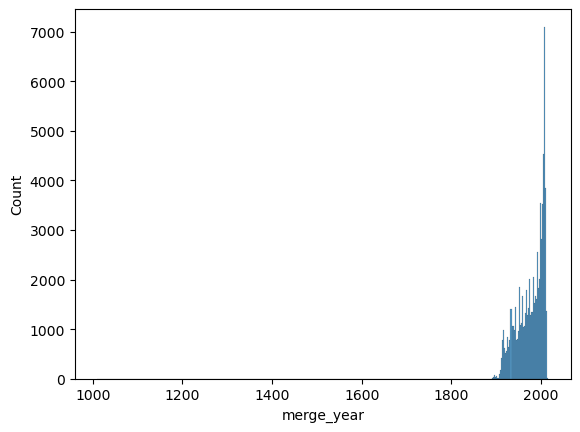

In [14]:
sns.histplot(x='merge_year', data=movie_plot)

#### There seems to be an outlier somewhere...

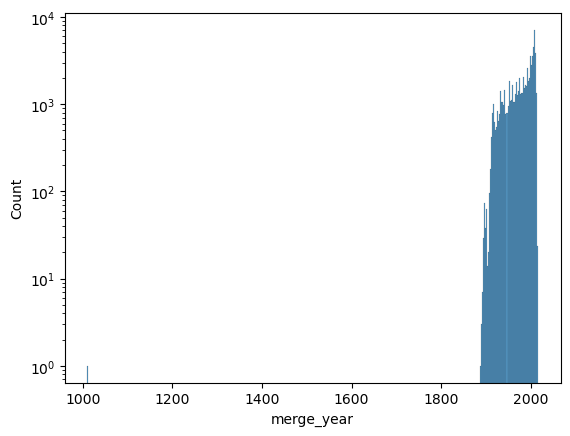

In [15]:
# Use log scale to detect outliers
hist = sns.histplot(x='merge_year', data=movie_plot)
hist.set_yscale('log')

In [16]:
# Find minimum year
movie_plot['merge_year'].min()

1010

#### Movie released in 1010 seems weird...

In [17]:
movie_plot[movie_plot['merge_year'] == 1010]

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]",Veteran homicide cop Ferman and his hot-heade...,1010


#### Hunting Season is a movie released in 2010, so must be a typo!

In [18]:
# Fix the year
movie_plot.loc[movie_plot['merge_year'] == 1010, 'merge_year'] = 2010
movie_plot.loc[movie_plot['ReleaseDate'] == '1010-12-02', 'ReleaseDate'] = '2010-12-02'
movie_plot[movie_plot['Name'] == 'Hunting Season']

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,Genres,Plot,merge_year
62836,29666067,/m/0fphzrf,Hunting Season,2010-12-02,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...","[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]",Veteran homicide cop Ferman and his hot-heade...,2010


#### Let's have a look at the languages included in our data

In [19]:
# Expand the languages and make a copy for further analysis
movie_languages_expanded = movie_plot.explode('Languages').reset_index(drop=True).copy()
movie_languages_expanded.shape

(95172, 13)

#### Let's see how the number of movies in the top 5 languages has evolved over time

In [20]:
# Filter for 5 most frequent languages
top_languages = movie_languages_expanded['Languages'].value_counts().nlargest(5).index
movie_languages_expanded['Languages'] = movie_languages_expanded['Languages'].apply(lambda x: x if x in top_languages else 'Other')

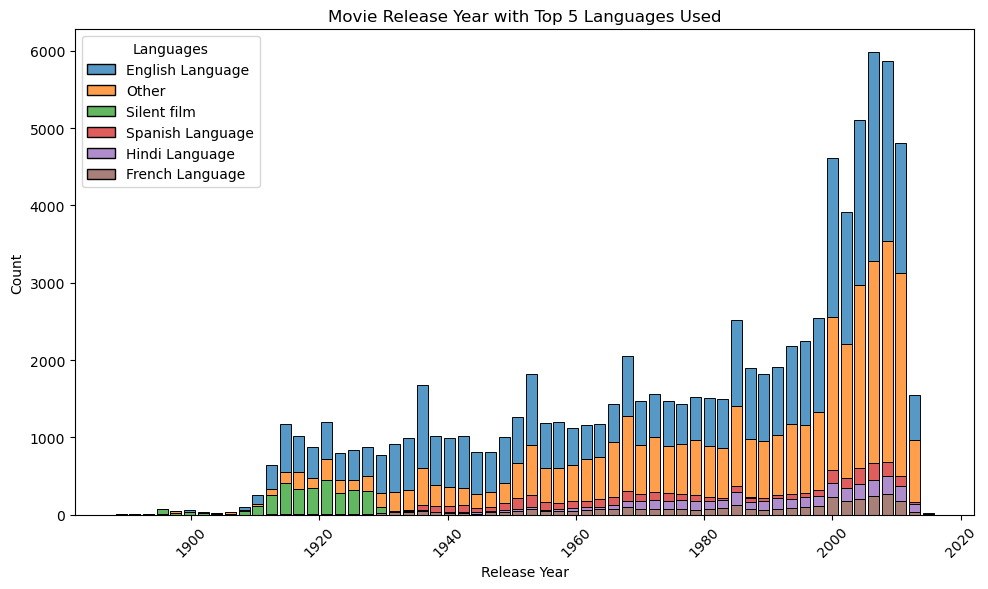

In [21]:
plt.figure(figsize=(10, 6))
# sns.histplot(data=movie_languages_expanded, x='merge_year', hue='Languages', multiple='stack', shrink=0.8, palette="tab10")
sns.histplot(data=movie_languages_expanded, x='merge_year', hue='Languages', multiple='stack', shrink=0.8)

handles, labels = plt.gca().get_legend_handles_labels()

plt.title('Movie Release Year with Top 5 Languages Used')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Let's see how the number of movies in the top 5 genres has evolved over time

In [22]:
# Expand the genres and make a copy for further analysis
movie_genres_expanded = movie_plot.explode('Genres').reset_index(drop=True).copy()
movie_genres_expanded.shape

(245623, 13)

In [23]:
# Filter for 5 most frequent genres
top_genres = movie_genres_expanded['Genres'].value_counts().nlargest(5).index
movie_genres_expanded['Genres'] = movie_genres_expanded['Genres'].apply(lambda x: x if x in top_genres else 'Other')

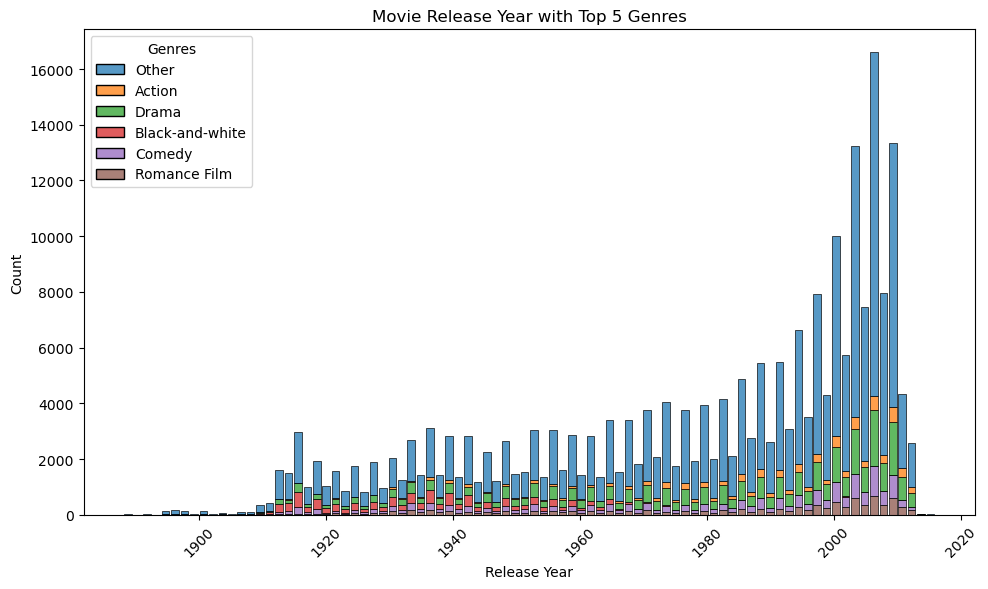

In [24]:
plt.figure(figsize=(10, 6))
# sns.histplot(data=movie_genres_expanded, x='merge_year', hue='Genres', multiple='stack', shrink=0.8, palette="tab10")
sns.histplot(data=movie_genres_expanded, x='merge_year', hue='Genres', multiple='stack', shrink=0.8)

handles, labels = plt.gca().get_legend_handles_labels()

plt.title('Movie Release Year with Top 5 Genres')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

### Extract Emotions from Movie Plots

In the next step we will extract the emotional tone of a film from the movie plot summaries. Therefore we use NRCLex, a python package which extract emotions from a given text, as well as two pre-trained language models from hugging face. The implementations for the extraction can be found in the emotion.py file in the utils folder, we will only apply the functions here to enrich the data and perform some initial analyses.

References:
Crowdsourcing a Word-Emotion Association Lexicon, Saif Mohammad and Peter Turney, Computational Intelligence, 29 (3), 436-465, 2013

#### Let's look at the plot lengths and their distribution first

Plot length statistics:
count    42204.000000
mean      1783.583594
std       1808.491453
min         99.000000
25%        508.000000
50%       1079.000000
75%       2602.000000
max      28159.000000
Name: Plot, dtype: float64


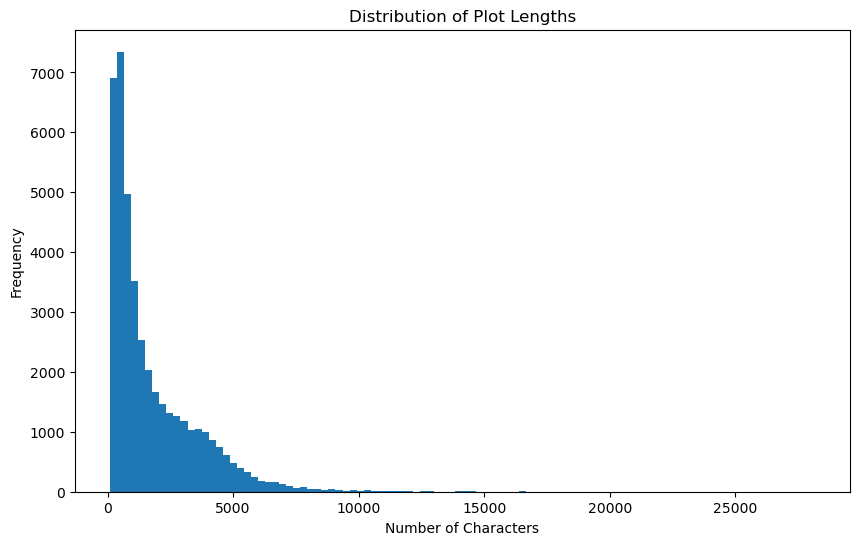

In [25]:
# Calculate plot lengths and show distribution
plot_lengths = movie_plot['Plot'].str.len().dropna()
print("Plot length statistics:")
print(plot_lengths.describe())

# Visualization
plt.figure(figsize=(10,6))
plt.hist(plot_lengths, bins=100)
plt.title('Distribution of Plot Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

#### Now we extract the emotions with NRCLex

In [26]:
# Import the created functions for emotion extraction
import sys
sys.path.append('../')
from utils.emotion import get_emotions_nrclex, get_emotions_roberta, get_emotions_distilbert

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [27]:
# Run NRCLex on all plots and save to new column
# Takes about a 60s
movie_plot['nrclex_emotions'] = movie_plot['Plot'].apply(lambda x: get_emotions_nrclex(x) if pd.notna(x) else None)

#### Let's check how the extracted emotions are distributed overall and across the top 10 genres

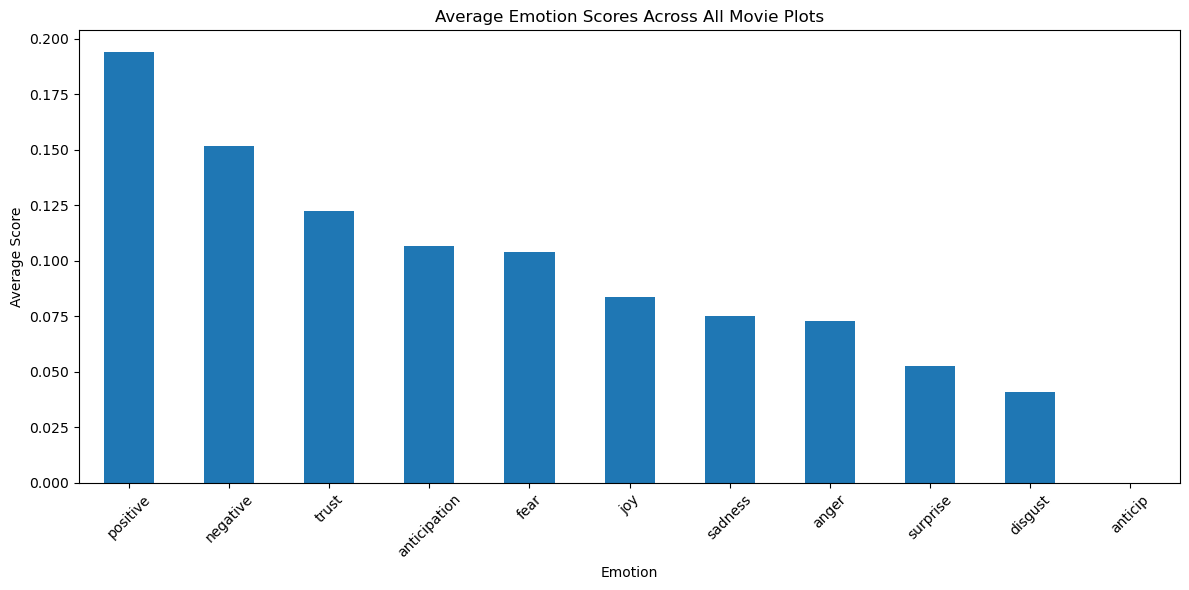

In [ ]:
# Extract emotions into separate columns for plotting
distilbert_emotions_df = pd.DataFrame(movie_plot['nrclex_emotions'].dropna().tolist())

# Calculate mean values
means = distilbert_emotions_df.mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
means.plot(kind='bar')
plt.title('Average Emotion Scores Across All Movie Plots')
plt.xlabel('Emotion')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Apparently positive and negative emotions are the most frequent, which is not surprising given how general they are. That trust is the third common emotion is a bit surprising, but we will look into that in detail in milestone 3...

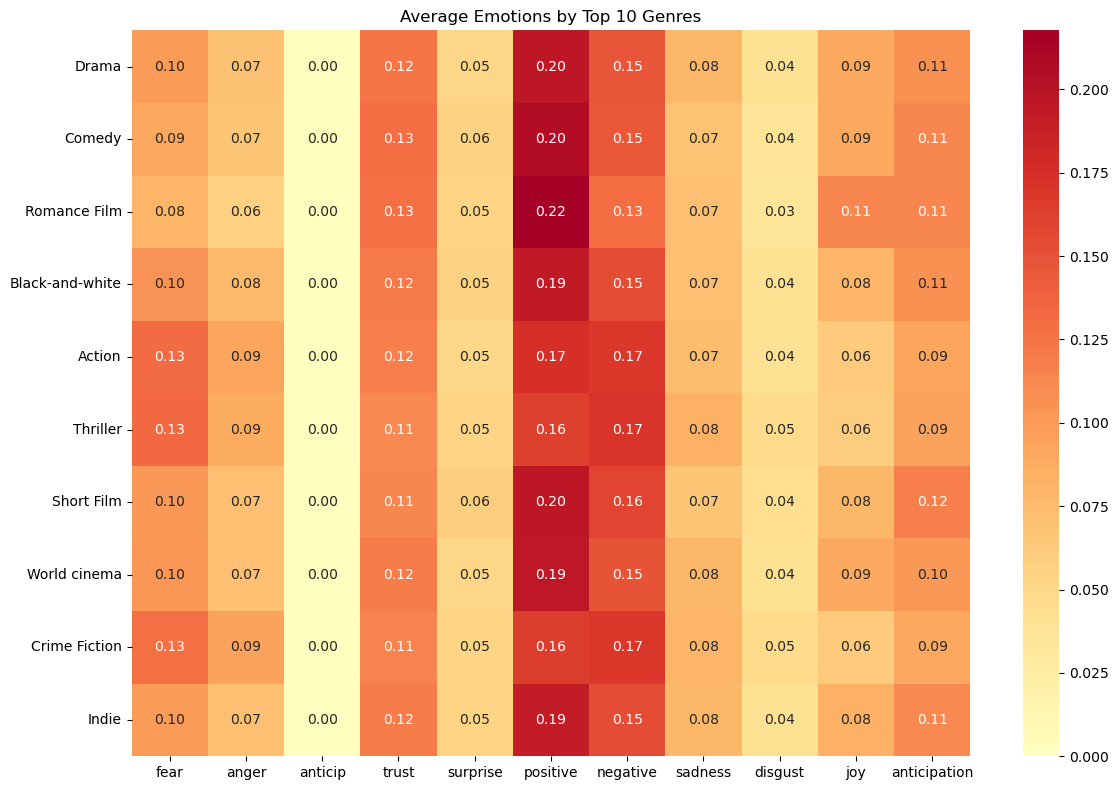

In [30]:
# Create a heatmap for the frequency of different emotions across genres
def plot_top_genres(emotions_col: str):

    all_genres = []
    for genres in movie_plot['Genres'].dropna():
        all_genres.extend(genres)

    # Get 10 most common genres
    top_10_genres = pd.Series(all_genres).value_counts().head(10).index

    # Filter movies by top genres and get their emotions
    genre_emotions = {}
    for genre in top_10_genres:
        movies_in_genre = movie_plot[movie_plot['Genres'].dropna().apply(lambda g: genre in g)]
        genre_emotions_list = movies_in_genre[emotions_col].dropna().tolist()
        genre_emotions[genre] = pd.DataFrame(genre_emotions_list).mean()

    # Convert to DataFrame for plotting
    genre_emotions_df = pd.DataFrame(genre_emotions).T

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_emotions_df, cmap='RdYlBu_r', center=0, annot=True, fmt='.2f')
    plt.title('Average Emotions by Top 10 Genres')
    plt.tight_layout()
    plt.show()

plot_top_genres('nrclex_emotions')

Nice, we already get some interesting results, regarding the distribution of different emotions across genres. Apparently anticip is not detected at all and surprise and sadness do not really vary over different genres. We could already start our analysis with this data but lets see if we can get even better results with pretrained language models.

#### Extract emotions with the pre-trained roberta-base-go-emotions model
Extracting the emotions with a pre-trained language model takes a lot of time and requires gpu to run in reasonable time. Therefore we just did it on a small subsample to ensure feasibility and will then for milestone 3 perform it on the complete dataset on external ressources like the EPFL cluster or Google Colab. We will then save the created data file and add it to the project.

The model we use is from huggingface: https://huggingface.co/SamLowe/roberta-base-go_emotions. It extracts 28 emotions from a given text and returns a dictionary with each emotion and the corresponding value.

In [31]:
# Extracting emotions takes a lot of time especially without gpu, so we check feasability by only performing it on the first 800 datapoints
df_subset = movie_plot[:4000].copy()

# Process with progress bar
from tqdm import tqdm
tqdm.pandas()
df_subset['roberta_emotions'] = df_subset['Plot'].progress_apply(lambda x: get_emotions_roberta(x) if pd.notna(x) else None)


100%|██████████| 4000/4000 [04:24<00:00, 15.15it/s]


#### Applying the pretrained model works very well! Let's plot the data we obtained and have a look at the top 3 emotions for the top 10 genres

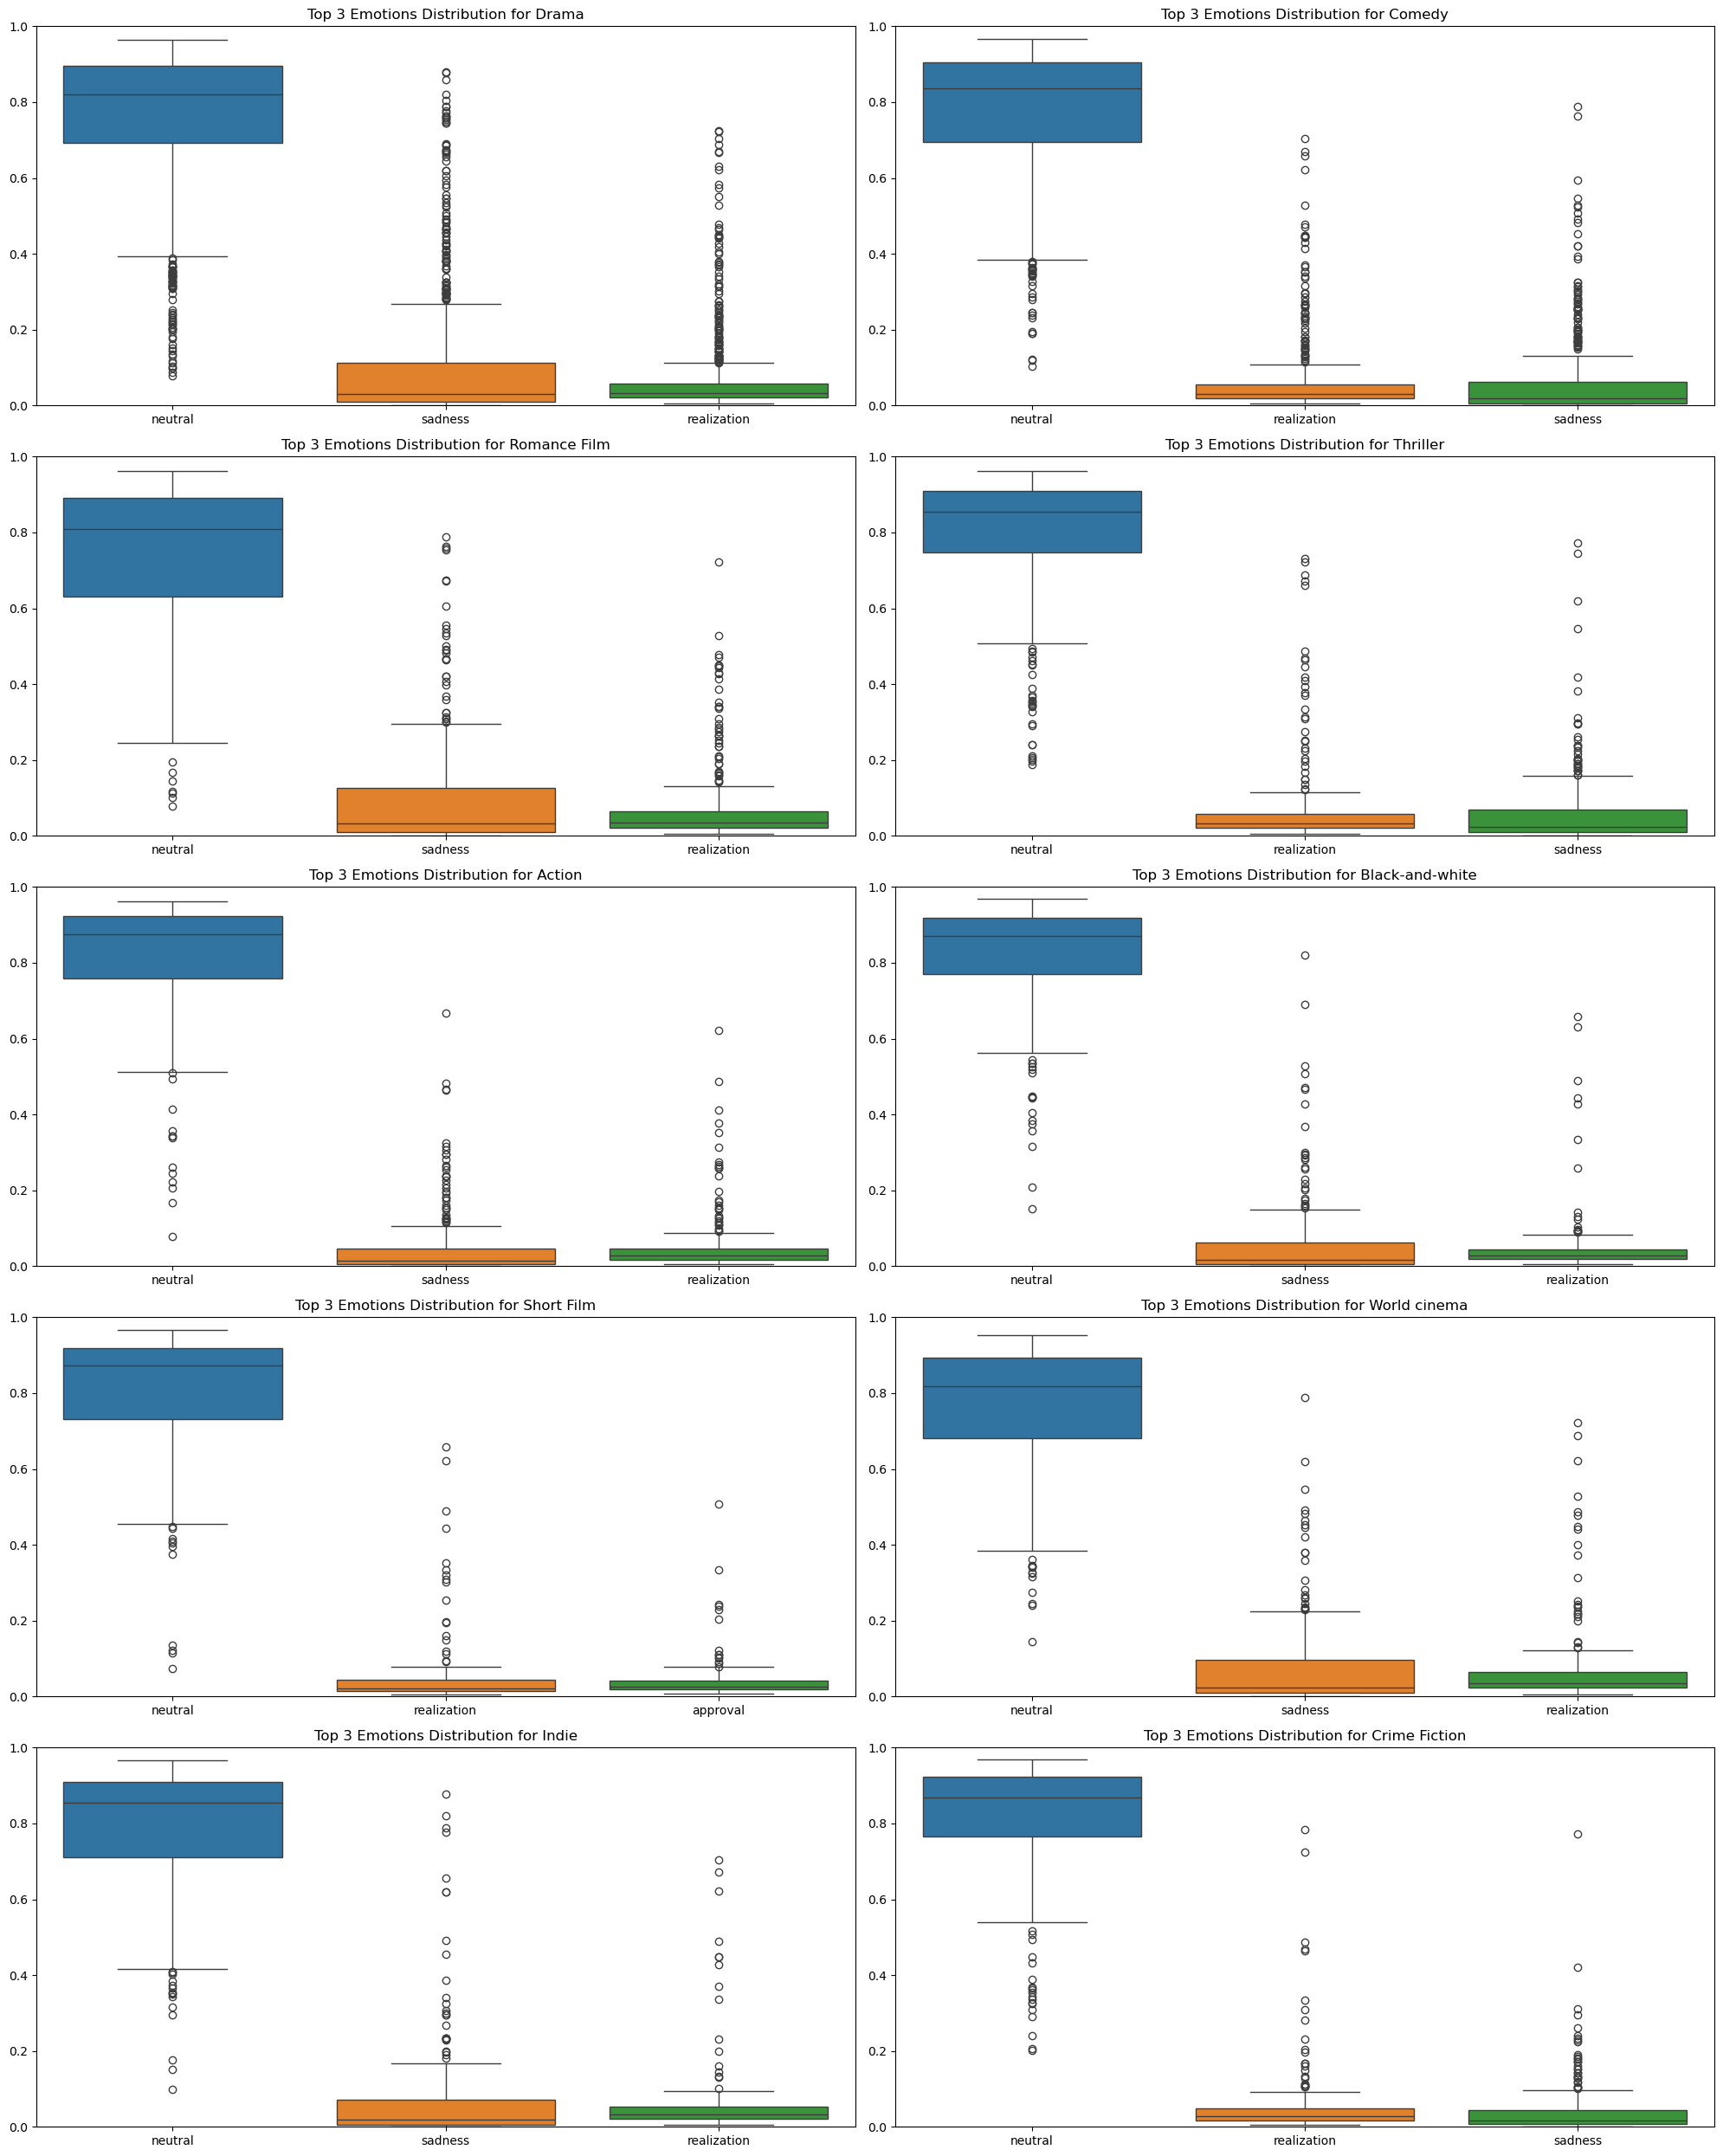

In [32]:
# Plot roberta emotions by genre

# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    distilbert_emotions = movies_in_genre['roberta_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))
    
    # Get top 3 emotions by mean value
    top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
    
    # Plot boxplot for this genre with only top 3 emotions
    sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i])
    axes[i].set_title(f'Top 3 Emotions Distribution for {genre}')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

That does not look too promising, the main emotion is always neutral and other then that it is always realization and sadness. Let's see how it looks when we omit the neutral emotion for now and look at the top 5 emotions instead.

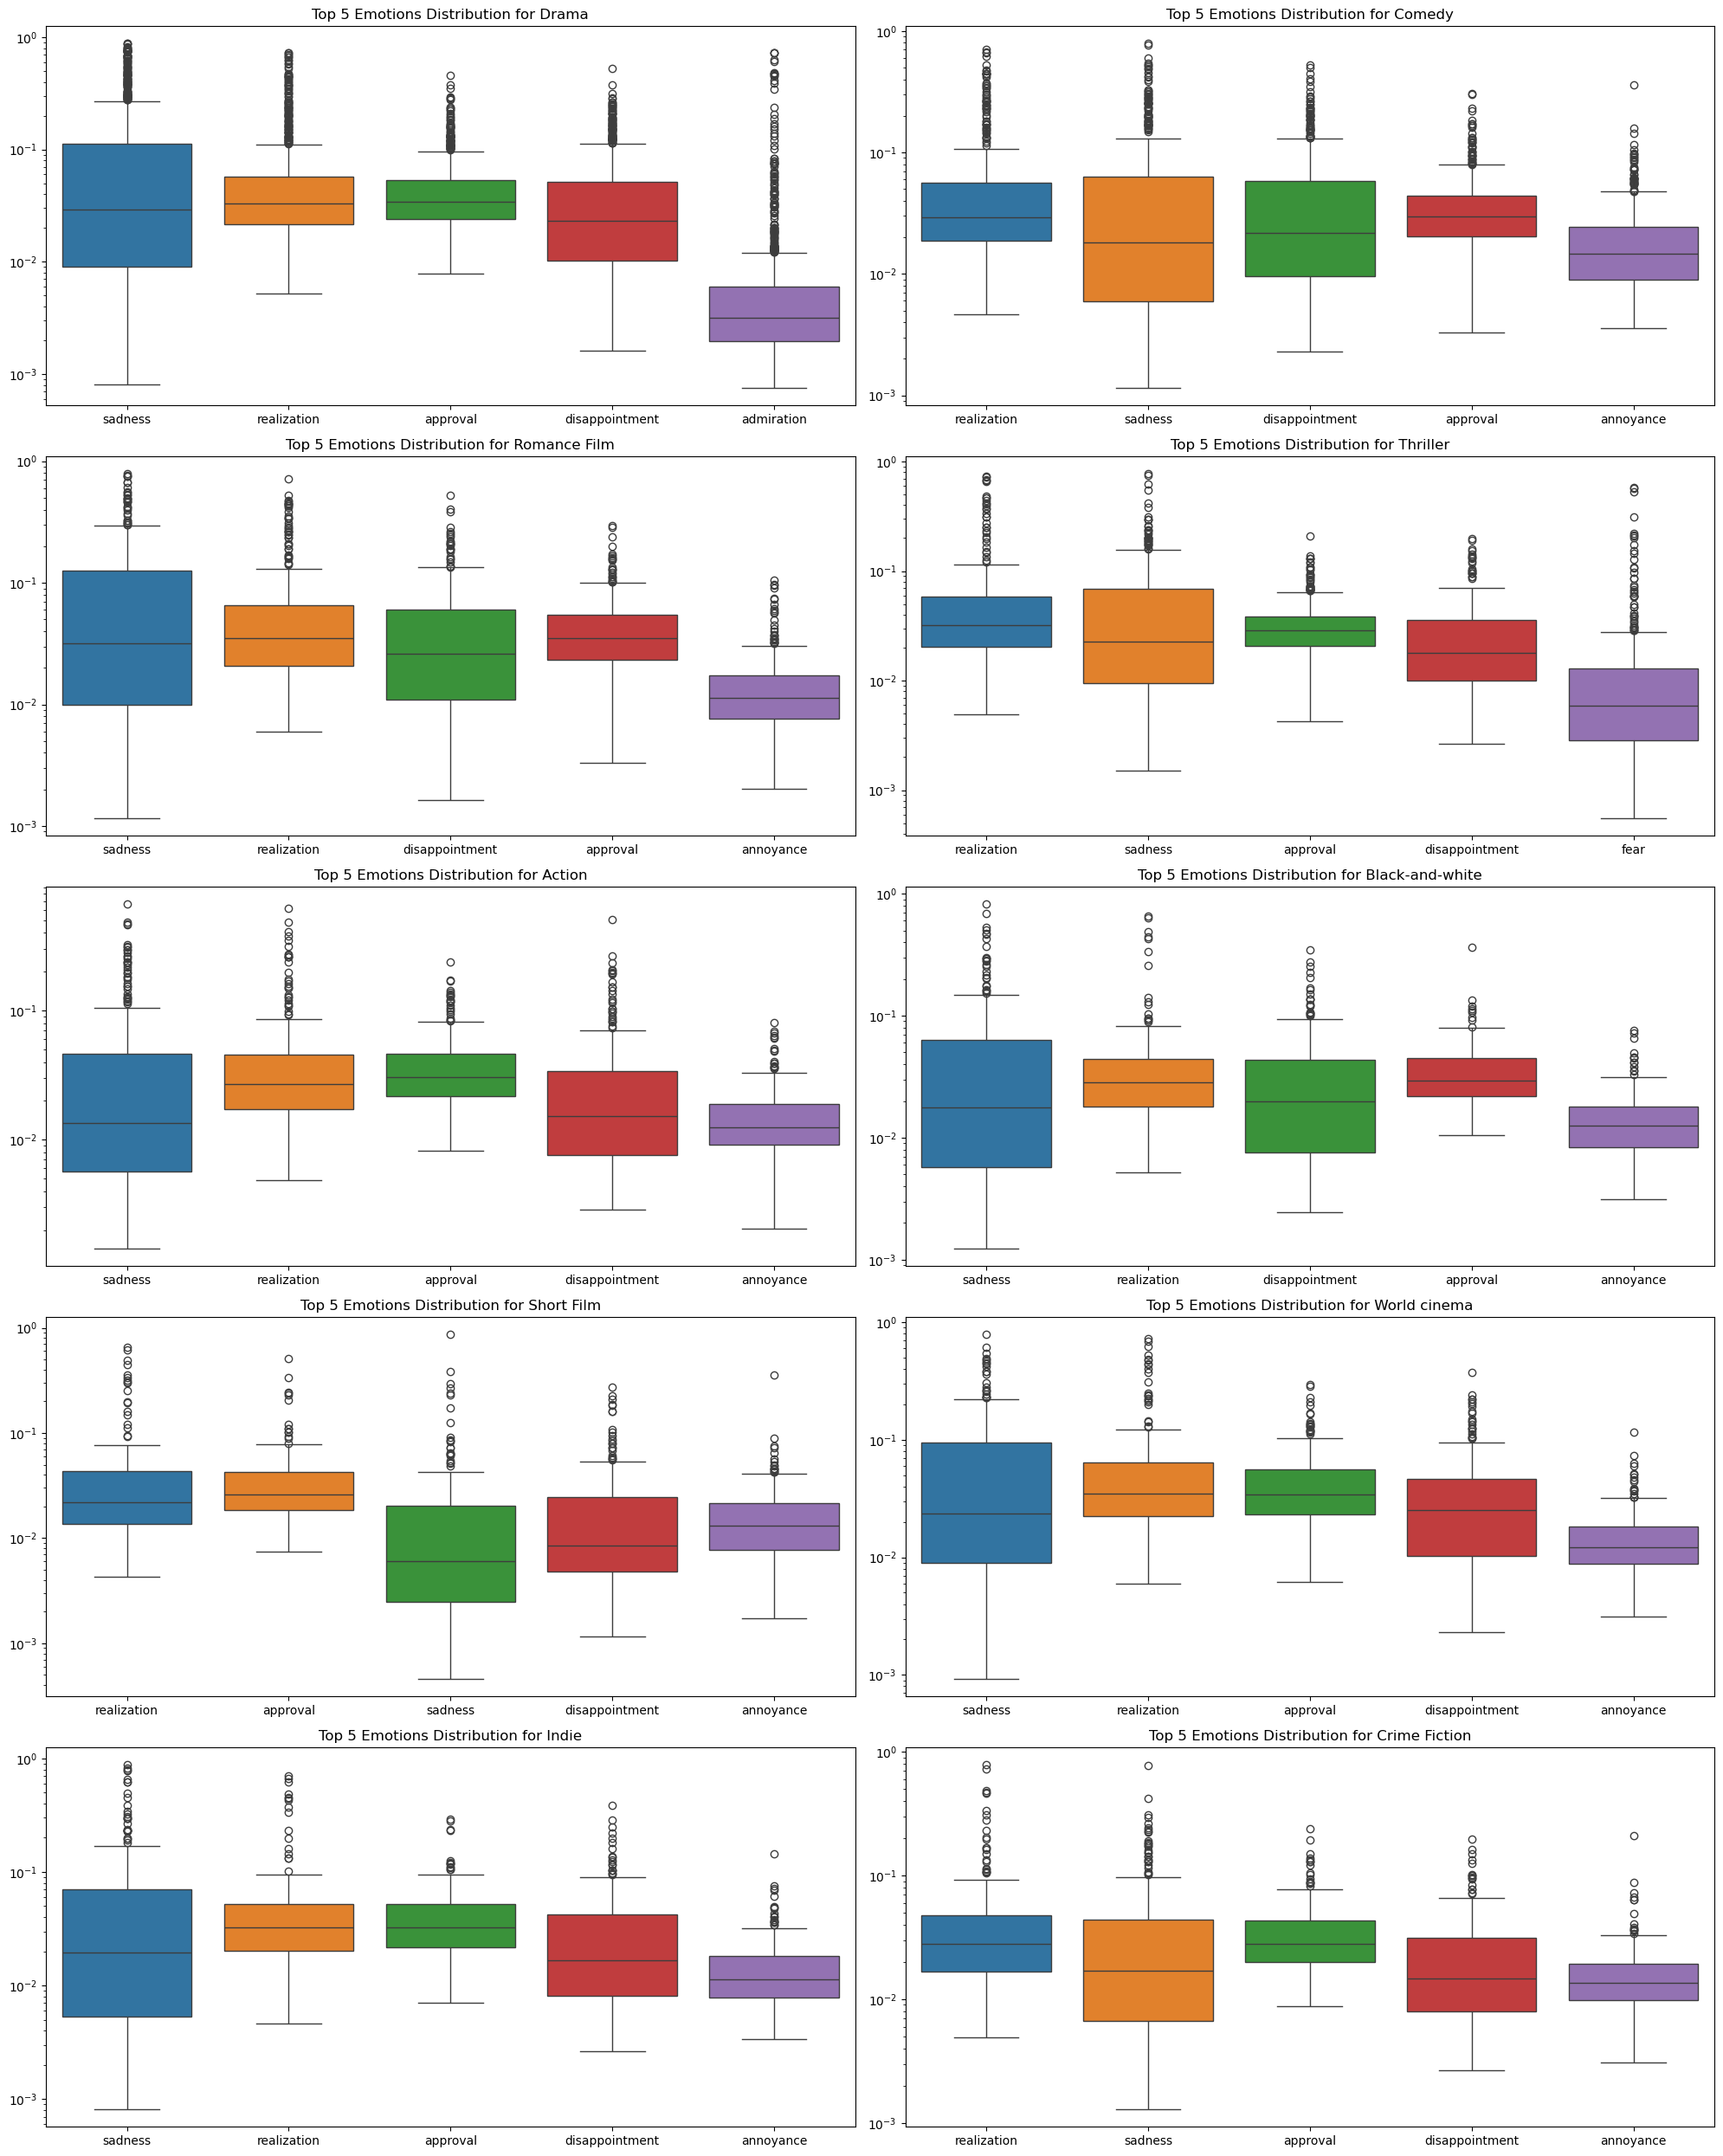

In [33]:
# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    roberta_emotions_no_neutral = movies_in_genre['roberta_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    emotions_df_no_neutral = pd.DataFrame(list(roberta_emotions_no_neutral))

    # Drop neutral
    emotions_df_no_neutral = emotions_df_no_neutral.drop(columns=['neutral'])
    
    # Get top 5 emotions by mean value
    top_5_emotions_no_neutral = emotions_df_no_neutral.mean().nlargest(5).index
    
    # Plot boxplot for this genre with only top 5 emotions
    plot = sns.boxplot(data=emotions_df_no_neutral[top_5_emotions_no_neutral], ax=axes[i])
    # Use log scale for better overview
    plot.set_yscale('log')
    axes[i].set_title(f'Top 5 Emotions Distribution for {genre}')

plt.tight_layout()
plt.show()

This still does not look very promising, there are more or less always the same top 5 emotions for the top 10 genres and they are more or less evenly distributed. That makes sense because there are 28 different emotions so it is difficult to really see a difference in the distribution of these emotions. Let's try another model which extract less emotions from the plot summaries.

#### Extract emotions with the pre-trained emotion-english-distilroberta-base model
This model is also from huggingface: https://huggingface.co/j-hartmann/emotion-english-distilroberta-base. It extracts Ekman's 6 basic emotions and a neutral class from a given text and returns a dictionary with each emotion and the corresponding value.

Again we only apply it only on a subset to check feasability and then for milestone 3 run it on the complete data on external ressources and add the created data to our project.

In [34]:
# Use again the subset and apply with progress bar
df_subset['distilbert_emotions'] = df_subset['Plot'].progress_apply(lambda x: get_emotions_distilbert(x) if pd.notna(x) else None)


100%|██████████| 4000/4000 [02:13<00:00, 29.88it/s]


#### This works fine as well! Let's look again at the top 3 emotions for the top 10 genres

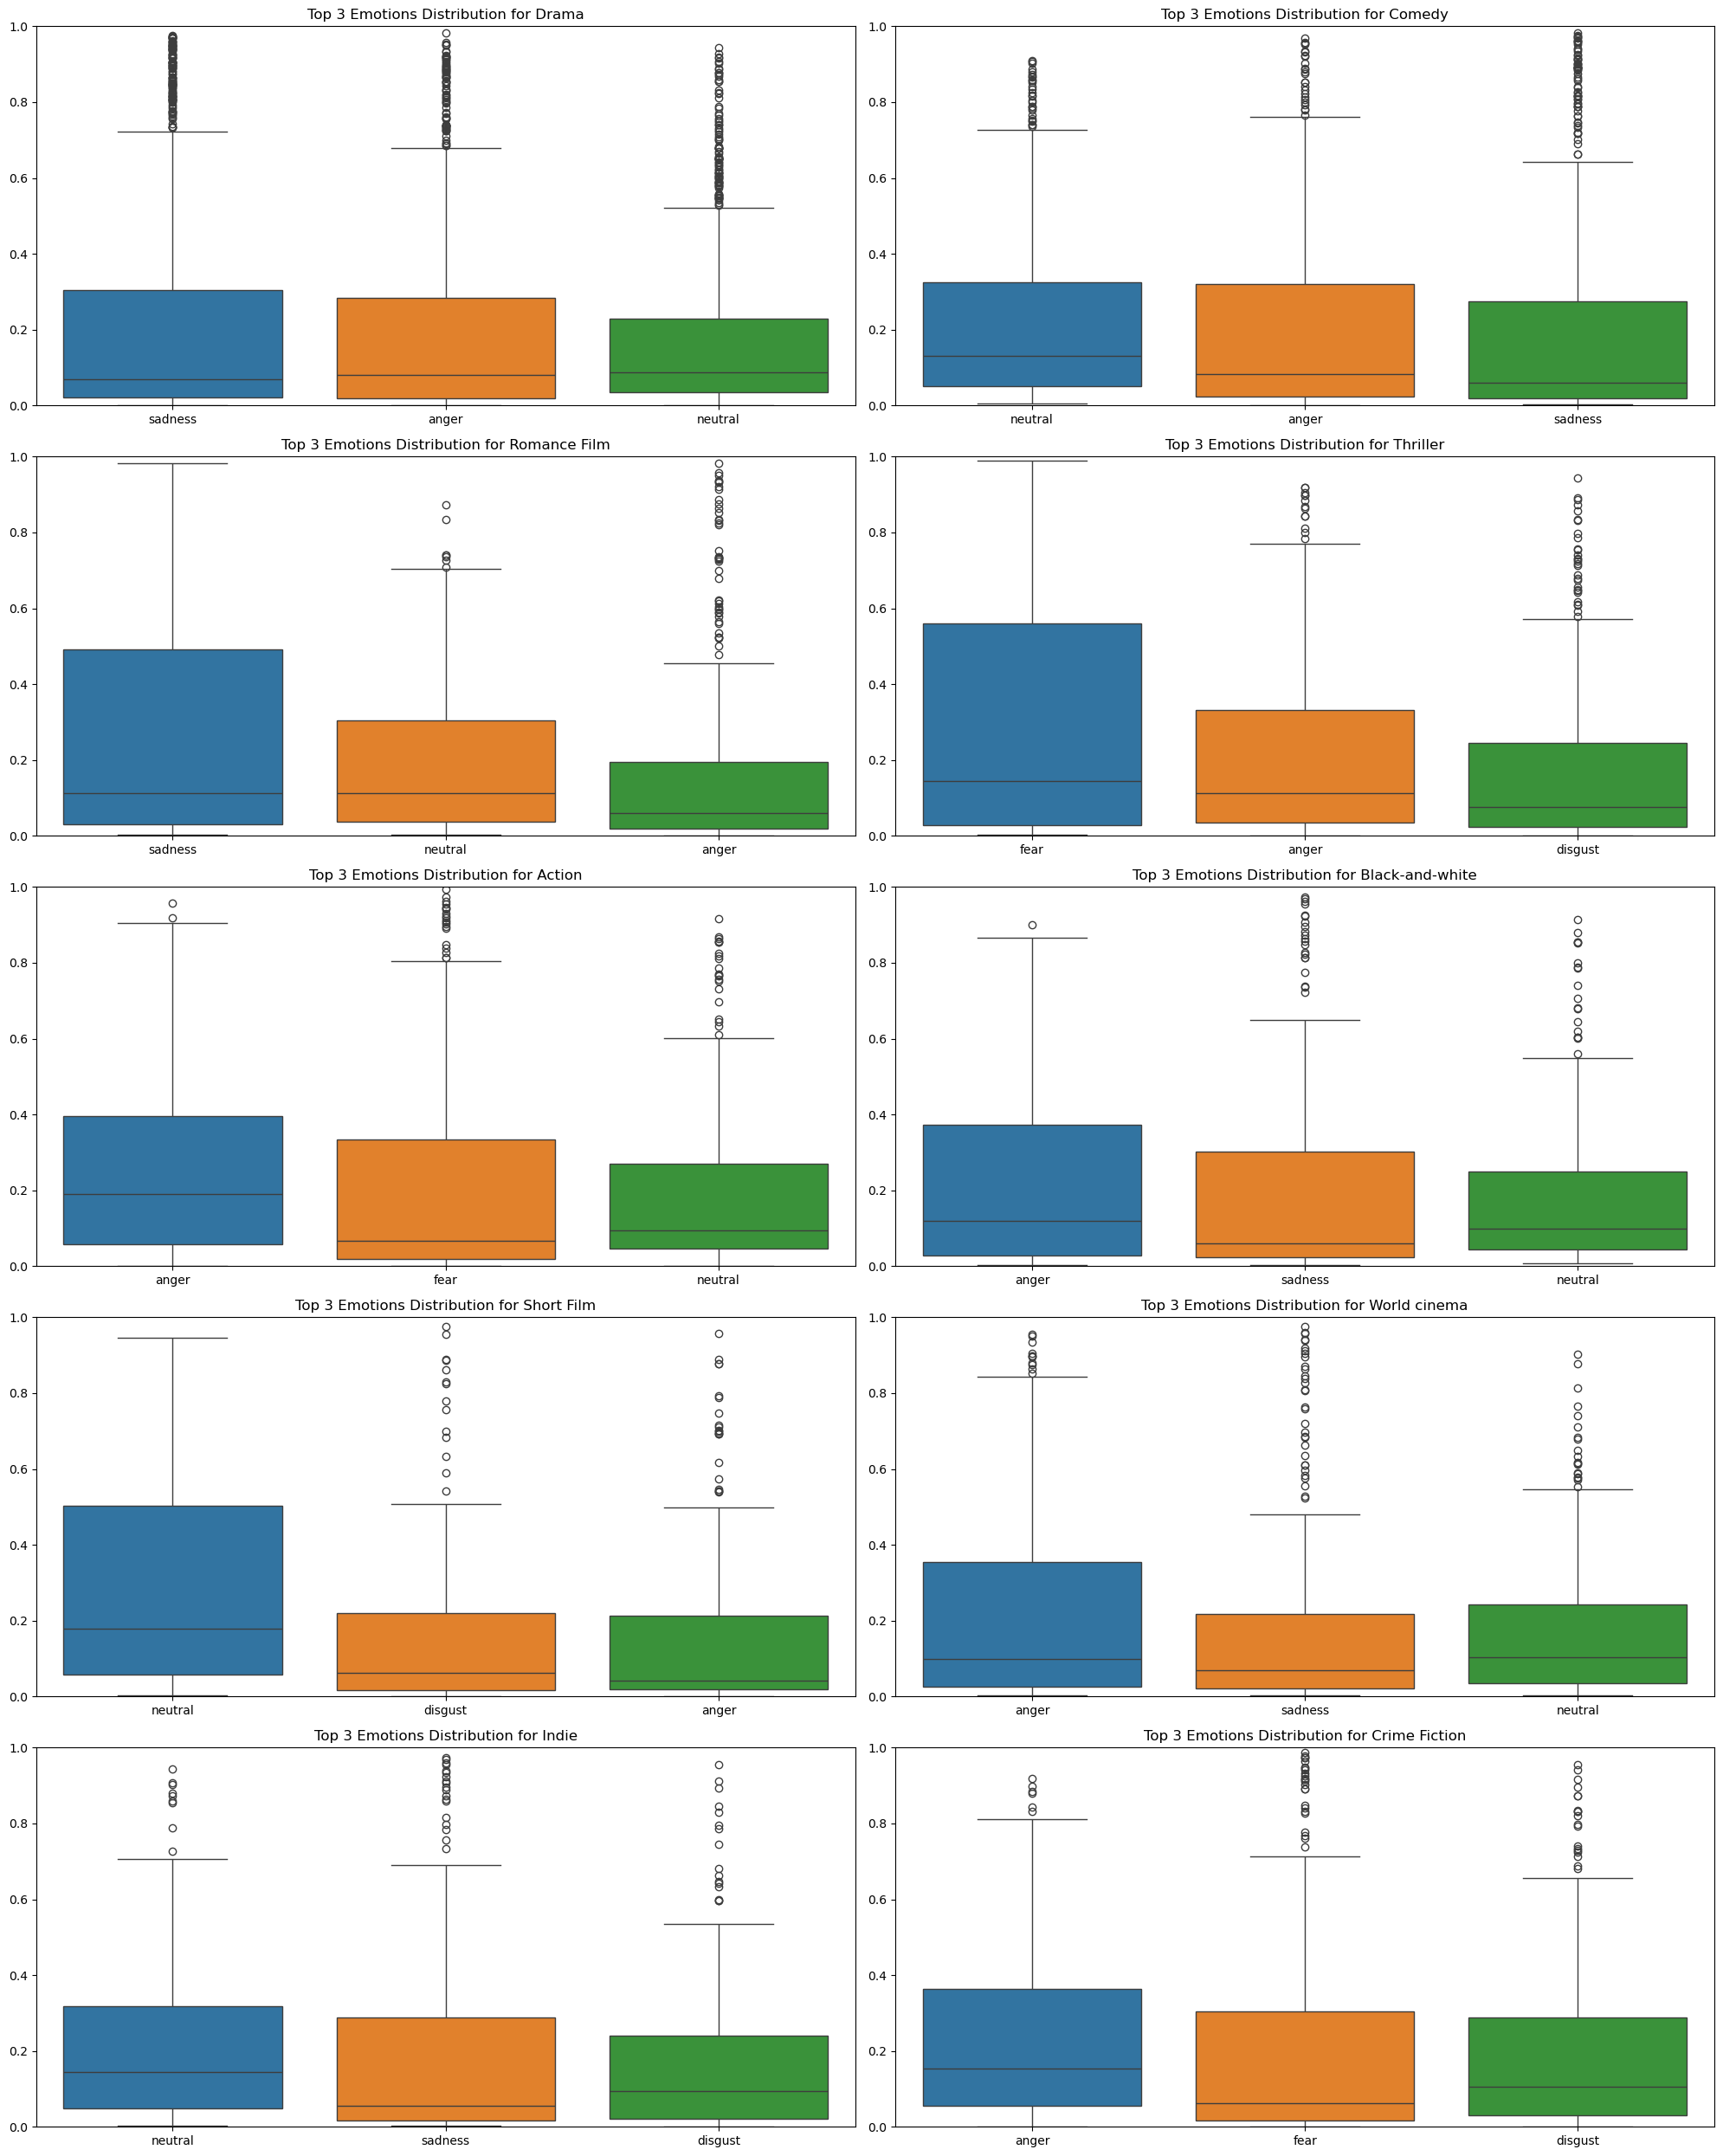

In [35]:
# Plot distilbert emotions by genre

# Group by genre and get mean of each emotion
all_genres = []
for genres in df_subset['Genres'].dropna():
    all_genres.extend(genres)

# Get 10 most common genres
top_10_genres = pd.Series(all_genres).value_counts().head(10).index

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()

# For each genre, get all the movies that belong to it and plot emotion distributions
for i, genre in enumerate(top_10_genres):
    movies_in_genre = df_subset[df_subset['Genres'].apply(lambda x: genre in x)]
    distilbert_emotions = movies_in_genre['distilbert_emotions'].dropna()
    
    # Convert list of dicts to DataFrame for easier plotting
    distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))
    
    # Get top 3 emotions by mean value
    top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
    
    # Plot boxplot for this genre with only top 3 emotions
    sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i])
    axes[i].set_title(f'Top 3 Emotions Distribution for {genre}')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

This looks way better, because we have less classes now there are clearer differences between the genres which is a great base for our further analyses.

Even though we only applied the emotion extraction on a subsample for now and will apply it on the whole dataset for milestone 3, we will add the three emotion extractions as columns to our data to have all columns which we will use for our final analysis.

---

### Character Data

In [34]:
characters = pd.read_csv('../../data/MovieSummaries/character.metadata.tsv', sep= '\t', header=None)
characters.columns = ['WikiMovieID', 'FreebaseMovieID', 'MovieReleaseDate','CharacterName',
                      'ActorBirthDate', 'ActorGender', 'ActorHeight','ActorEthnicity', 
                      'ActorName', 'ActorAge', 'CharacterActorMap', 'CharacterID', 'ActorID']
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,CharacterActorMap,CharacterID,ActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Lets delve deeper into the character dataset

In [ ]:
# Check for missing values
pd.isna(characters).sum() / len(characters)

WikiMovieID          0.000000
FreebaseMovieID      0.000000
MovieReleaseDate     0.022178
CharacterName        0.572205
ActorBirthDate       0.235528
ActorGender          0.101203
ActorHeight          0.656457
ActorEthnicity       0.764665
ActorName            0.002725
ActorAge             0.350841
CharacterActorMap    0.000000
CharacterID          0.572183
ActorID              0.001808
dtype: float64

Apparently a lot of values for the ethnicity of actors is missing. For us the age and gender seem more important in regards of the influence of emotions in movies so we will not use the ethnicity. Furthermore the height and name of an actor is not interesting for us as well as the CharacterActorMap, CharacterID and the ActorID because they refer to freebase which does not exist anymore. We do not intend to use the CharacterName for now but maybe it will useful later. Lets get rid of the columns we won't use to make the data more easy to understand.

In [ ]:
# Drop unused columns
characters = characters.drop(['ActorHeight', 'ActorEthnicity', 'ActorName', 'CharacterActorMap', 'CharacterID', 'ActorID'], axis=1)
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,42.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,27.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,32.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,33.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,23.0


From the remaining columns we will use ActorGender and ActorAge for our analysis. Therefore we should replace NaN values. For the age we will try to calculate it from the movie release date and the actor birth date. If this does not work we just use the mean which is a common technique. For the gender we will first look what is the distribution of the gender across the actors in the dataset and generate the gender randomly according to the distribution.

In [ ]:
# Convert birth and movie release date to datetime
def clean_date(date):
    try:
        return pd.to_datetime(date, errors='coerce')
    except OutOfBoundsDatetime:
        return pd.NaT

characters['ActorBirthDate'] = characters['ActorBirthDate'].apply(clean_date)
characters['MovieReleaseDate'] = characters['MovieReleaseDate'].apply(clean_date)

# Calculate age based on birth and movie release date, use mean if one of the dates is missing
def calculate_age(birth_date, movie_date):
    if pd.isna(birth_date):
        # Without birth date the age can't be calculate, replace age with mean
        return characters['ActorAge'].mean()
    if pd.isna(movie_date):
        # Without movie release date the age can't be calculate, replace age with mean
        return characters['ActorAge'].mean()
    age = movie_date.year - birth_date.year - ((movie_date.month, movie_date.day) < (birth_date.month, birth_date.day))
    return age

# Recalculate age for all rows where the age is NaN
characters['ActorAge'] = characters.apply(
    lambda row: calculate_age(row['ActorBirthDate'], row['MovieReleaseDate']) if pd.isna(row['ActorAge']) else row['ActorAge'], 
    axis=1)

In [39]:
# Replace NaN values in gender with a value according to distribution
gender_distribution = characters['ActorGender'].value_counts(normalize=True)

def assign_random_gender():
    return np.random.choice(gender_distribution.index, p=gender_distribution.values)

characters['ActorGender'] = characters['ActorGender'].apply(lambda x: assign_random_gender() if pd.isna(x) else x)

# Check if NaN values are successfully replaced
pd.isna(characters).sum() / len(characters)

WikiMovieID         0.000000
FreebaseMovieID     0.000000
MovieReleaseDate    0.022211
CharacterName       0.572205
ActorBirthDate      0.235579
ActorGender         0.000000
ActorAge            0.000000
dtype: float64

The actor gender is not numerically encoded which makes a little bit more difficult to calculate distributions and other statistics. So we add a column ActorGenderFlag which encodes the gender numerically. First we will check which values for the gender exist in the data and then encode the values numerically.

In [41]:
characters['ActorGender'].value_counts()

ActorGender
M    300636
F    150033
Name: count, dtype: int64

In [42]:
# Flag will be 0 if the actor is male and 1 if the actor is female
characters['ActorGenderFlag'] = np.where(characters['ActorGender'] == 'F', 1, 0)
characters.head()

,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge,ActorGenderFlag
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,42.0,1
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,27.0,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,32.0,0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,33.0,0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,23.0,1


Lets get a first overview over the distribution of values on the remaining data.

In [43]:
characters.describe()

,WikiMovieID,MovieReleaseDate,ActorAge,ActorGenderFlag
count,4.506690e+05,440659,450669.000000,450669.000000
mean,1.396975e+07,1984-11-10 22:25:30.832684736,38.386498,0.332912
min,3.300000e+02,1888-01-01 00:00:00,-7896.000000,0.000000
25%,3.759292e+06,1969-01-01 00:00:00,31.000000,0.000000
50%,1.189065e+07,1994-01-01 00:00:00,37.788523,0.000000
75%,2.366501e+07,2005-08-20 00:00:00,44.000000,1.000000
max,3.750192e+07,2016-06-08 00:00:00,156.000000,1.000000
std,1.079662e+07,NaN,17.284183,0.471256


The average age of actors is 37 but has a high standard deviation so it seems to vary a lot. From the included actors around 70% are male and 30% are female. Which seems weird is the minimum age of -7896 and the maximum age of 103. The maximum age could be realistic but the minimum age definitely not. So lets check all age values below 0 to identify potential mistakes in the data.

In [44]:
extreme_ages = characters[(characters['ActorAge'] <= 0)]
print("Number of datapoints with an age below 0: ", len(extreme_ages))
extreme_ages

Number of datapoints with an age below 0:  470


,WikiMovieID,FreebaseMovieID,MovieReleaseDate,CharacterName,ActorBirthDate,ActorGender,ActorAge,ActorGenderFlag
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07 00:00:00,M,-29.0,0
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25 00:00:00,M,-12.0,0
3892,5917218,/m/0fdf3y,1965-01-01,NaN,1983-03-03 00:00:00,F,-18.0,1
6666,73930,/m/0jsjm,1924-01-01,Robert,1972-11-07 00:00:00,M,-48.0,0
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01 00:00:00,M,-17.0,0
...,...,...,...,...,...,...,...,...
446581,25868401,/m/09v6ykm,1955-01-01,NaN,1967-05-31 00:00:00,F,-12.0,1
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28 00:00:00,M,-3.0,0
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19 00:00:00,M,-15.0,0
447210,23382222,/m/06w1hlj,1932-08-09,NaN,1942-02-08 00:00:00,M,-9.0,0


Apparently there are 470 datapoints with a negative age. These ages have to be a mistake of some kind, which can also be seen when looking at the birth date. For each negative value we correct the age by calculating the correct age with the birth date and movie release date, we will use the code from before but adjust it slightly to clean negative values correctly even if one of the dates might be wrong and clean unrealistic high values as well.

In [48]:
# Calculate the age, if value is still negative or too high return mean
def calculate_age_non_negative(birth_date, movie_date):
    if pd.isna(birth_date):
        # Without birth date the age can't be calculate, replace age with mean
        return characters['ActorAge'].mean()
    if pd.isna(movie_date):
        # Without movie release date the age can't be calculate, replace age with mean
        return characters['ActorAge'].mean()
    age = movie_date.year - birth_date.year - ((movie_date.month, movie_date.day) < (birth_date.month, birth_date.day))
    return age if 0 < age < 103 else characters['ActorAge'].mean()

# Recalculate age for all rows where the age is below 0 or above 103
characters['ActorAge'] = characters.apply(
    lambda row: calculate_age_non_negative(row['ActorBirthDate'], row['MovieReleaseDate']) if row['ActorAge'] < 0 or row['ActorAge'] >= 103 else row['ActorAge'], 
    axis=1)

# Check the results
characters.describe()

,WikiMovieID,MovieReleaseDate,ActorAge,ActorGenderFlag
count,4.506690e+05,440659,450669.000000,450669.000000
mean,1.396975e+07,1984-11-10 22:25:30.832684736,38.454345,0.332912
min,3.300000e+02,1888-01-01 00:00:00,0.000000,0.000000
25%,3.759292e+06,1969-01-01 00:00:00,31.000000,0.000000
50%,1.189065e+07,1994-01-01 00:00:00,37.788523,0.000000
75%,2.366501e+07,2005-08-20 00:00:00,44.000000,1.000000
max,3.750192e+07,2016-06-08 00:00:00,100.000000,1.000000
std,1.079662e+07,NaN,12.312417,0.471256


Now the values seem realistic and are prepared for further analysis. In a last step we look at the distribution of the age and gender which we want to use later on for further analysis to get an idea of the data we work with.

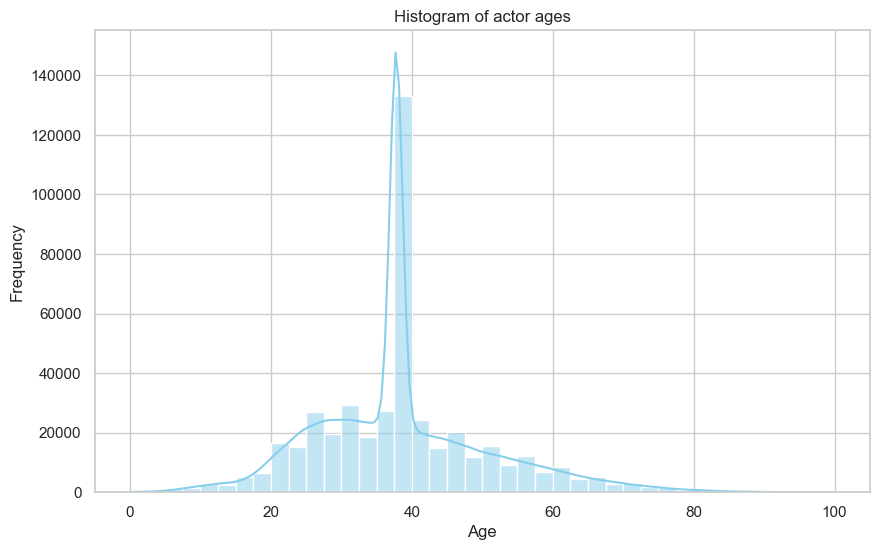

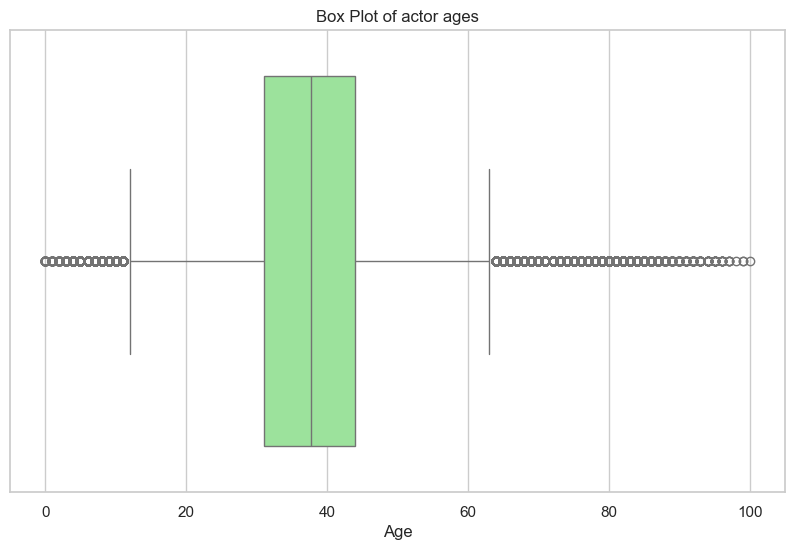

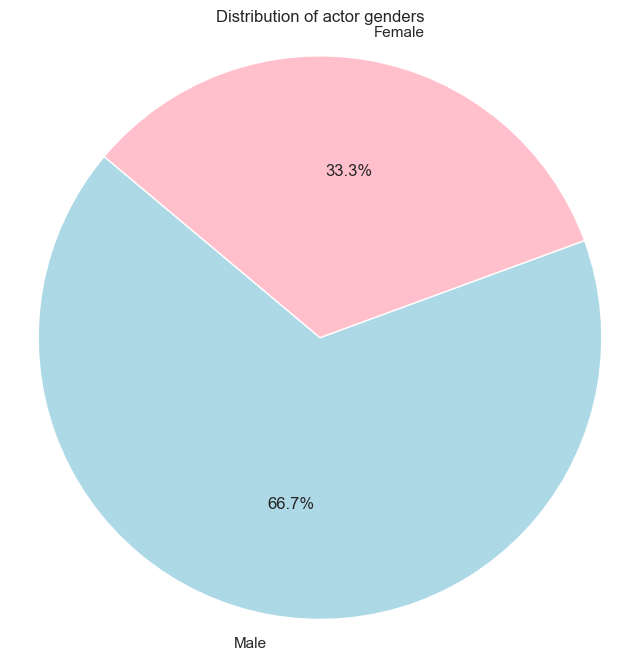

In [50]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

# Histogram for the age of actors
plt.figure(figsize=(10, 6))
sns.histplot(characters['ActorAge'], bins=40, kde=True, color='skyblue')
plt.title("Histogram of actor ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Box Plot for age of actors
plt.figure(figsize=(10, 6))
sns.boxplot(x=characters['ActorAge'], color='lightgreen')
plt.title("Box Plot of actor ages")
plt.xlabel("Age")
plt.show()

# Pie Chart for the gender of actors using the ActorGenderFlag
gender_counts = characters['ActorGenderFlag'].value_counts()
labels = ['Male', 'Female'] 
colors = ['lightblue', 'pink']
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of actor genders")
plt.axis('equal')
plt.show()

The visualizations show what we already saw with describe() earlier. The age is more or less evenly distributed around the mean of 37. The boxplot shows that the middle 50% of the ages are roughly between 15 and 62. 

The gender is not evenly distributed. Around 2/3 of the actors which are included in the data are male. This has to be considered in later analyses especially when looking at impact of emotions in a movie on the gender of selected actors in that movie.